# IX.C. Infomap Bioregions

Biogeographical regions, or bioregions, capture the spatial organization of life on Earth.

Infomap Bioregions transforms species distribution data to bioregional maps using Infomap to detect modules in a bipartite network between grid cells and species.

<img src="https://www.mapequation.org/assets/img/bioregions/schematics-wrap.svg" alt="Infomap Bioregions" width=600 style="background-color: white; padding: 10px">

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
import shapely
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%reload_ext autoreload
%autoreload 2
import util

In [3]:
sns.set_style('whitegrid')

In [4]:
np.random.seed(0)
np.random.randint(0, 100)

44

## Step 1 - bin species distribution to grid cells
<img src="https://www.mapequation.org/assets/img/bioregions/schematics-quadtree-mapping.svg" alt="step-1" height=200 style="background-color: white; padding: 10px">

Here we generate synthetic data for demo purposes.

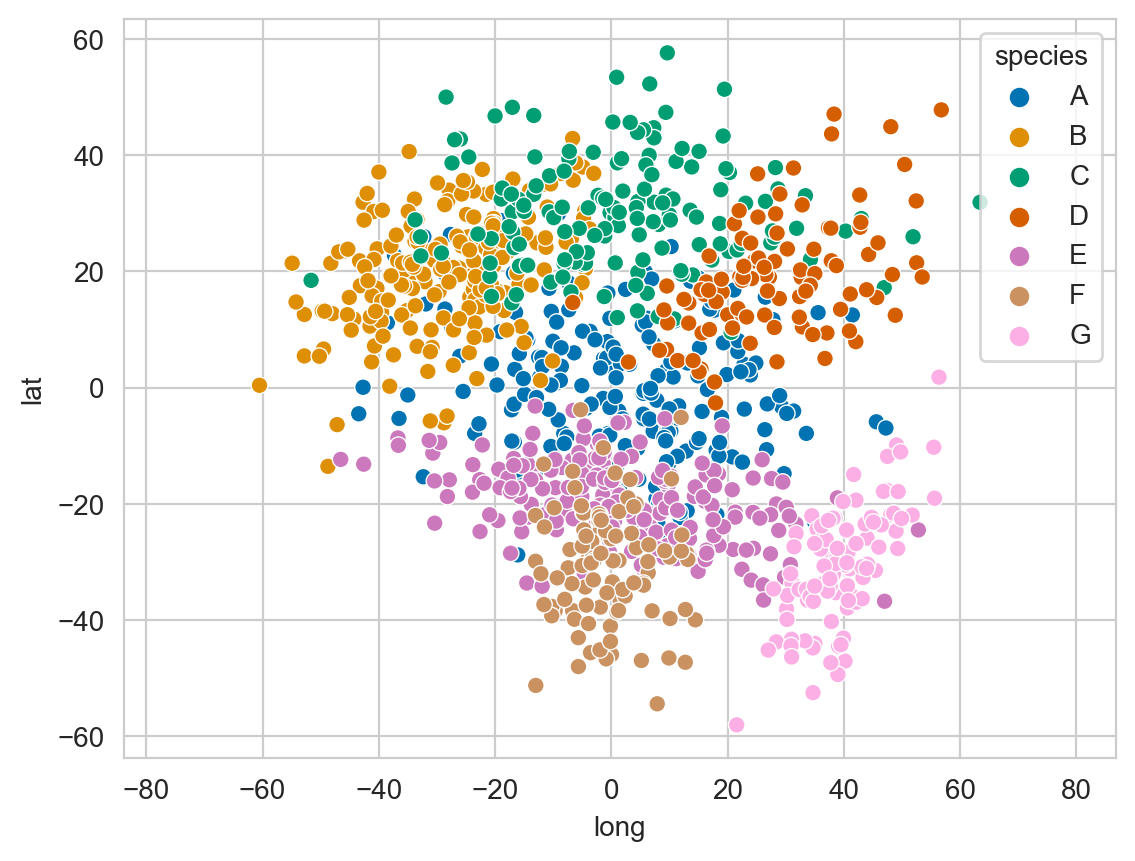

In [5]:
def sample_species_distribution(mean, cov, n_samples, name):
    df = pd.DataFrame(np.random.multivariate_normal(mean, cov, n_samples), columns=['long', 'lat'])
    df['species'] = name
    return df

species_params = [
    dict(mean=[0,0], cov=[[300, -50], [-50, 150]], n_samples=200, name="A"),
    dict(mean=[-30,20], cov=[[150, 50], [50, 100]], n_samples=200, name="B"),
    dict(mean=[0,30], cov=[[400, 0], [0, 100]], n_samples=150, name="C"),
    dict(mean=[30,20], cov=[[150, 50], [50, 100]], n_samples=100, name="D"),
    dict(mean=[0,-20], cov=[[300, -50], [-50, 50]], n_samples=200, name="E"),
    dict(mean=[0,-30], cov=[[50, 0], [0, 100]], n_samples=100, name="F"),
    dict(mean=[40,-30], cov=[[50, 50], [50, 100]], n_samples=100, name="G"),
]
def generate_species_distributions(species_params, seed=0):
    np.random.seed(seed)
    return pd.concat([sample_species_distribution(**params) for params in species_params], ignore_index=True)

df_records = generate_species_distributions(species_params)
sns.scatterplot(df_records, x="long", y="lat", hue="species").axis('equal');


23 cells generated!


,ilat,ilong,cell_name,geometry,bioregion
cell_id,,,,,
5,-1.0,-1.0,-1.0_-1.0,"POLYGON ((0.00000 -25.00000, 0.00000 0.00000, ...",0
2,-1.0,-2.0,-1.0_-2.0,"POLYGON ((-25.00000 -25.00000, -25.00000 0.000...",0
8,-1.0,0.0,-1.0_0.0,"POLYGON ((25.00000 -25.00000, 25.00000 0.00000...",0
6,-1.0,1.0,-1.0_1.0,"POLYGON ((50.00000 -25.00000, 50.00000 0.00000...",0
19,-1.0,2.0,-1.0_2.0,"POLYGON ((75.00000 -25.00000, 75.00000 0.00000...",0


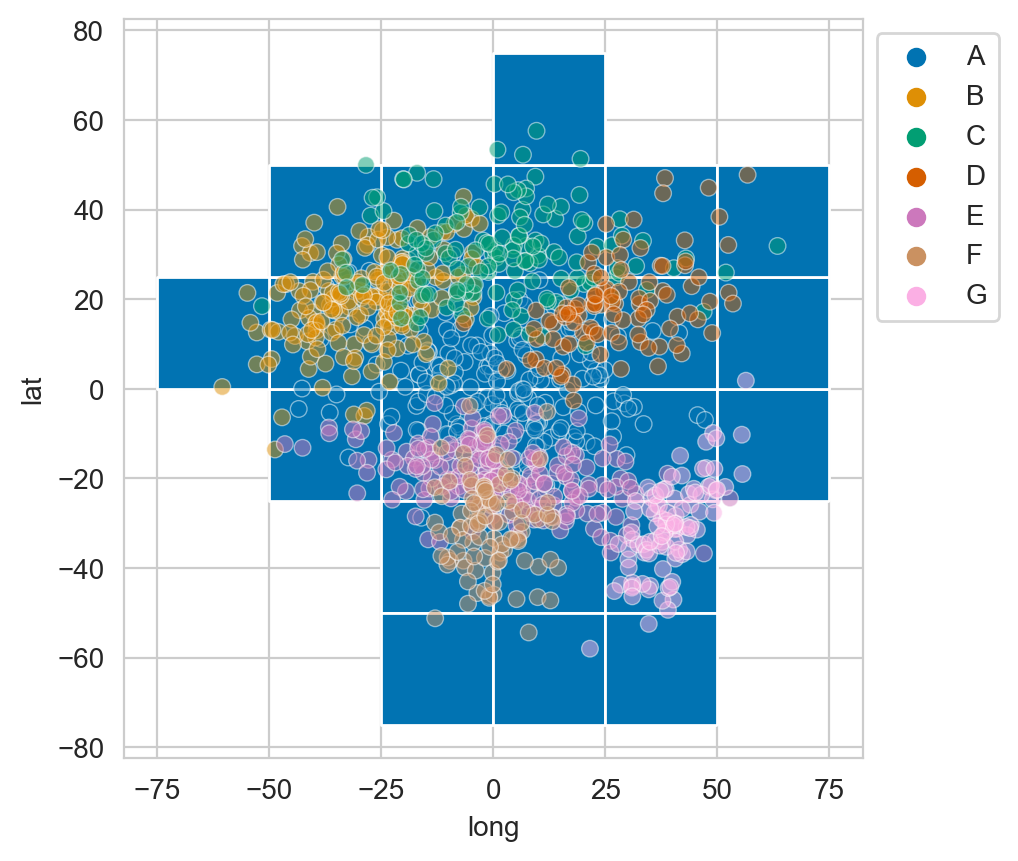

In [19]:
def bin_species(df_records, resolution):
    df = df_records
    df["ilat"] = df["lat"] // resolution
    df["ilong"] = df["long"] // resolution
    df["ilat_ilong"] = df.apply(lambda row: f"{row['ilat']}_{row['ilong']}", axis=1)

    cell_ids = df["ilat_ilong"].unique()
    cell_ids = pd.Series(range(cell_ids.shape[0]), index=cell_ids)
    df["cell_id"] = df.apply(lambda row: cell_ids.loc[row["ilat_ilong"]], axis=1)

    df_cells = (
        df[["ilat", "ilong", "ilat_ilong"]]
        .groupby("ilat_ilong")
        .agg({"ilat": "first", "ilong": "first"})
    )
    num_cells = df_cells.shape[0]
    df_cells["cell_id"] = cell_ids[df_cells.index]
    df_cells["cell_name"] = df_cells.index
    df_cells = df_cells.set_index("cell_id")
    print(f"{num_cells} cells generated!")

    def create_cell(row):
        lat = row["ilat"] * resolution
        long = row["ilong"] * resolution
        return shapely.geometry.box(
            long, lat, long + resolution, lat + resolution
        )

    df_cells["geometry"] = df_cells.apply(create_cell, axis=1)
    df_cells = gpd.GeoDataFrame(df_cells, crs="EPSG:4326")
    df_cells["bioregion"] = 0
    
    return df_cells

df_cells = bin_species(df_records, resolution=25)

ax = df_cells.plot()
sns.scatterplot(df_records, x="long", y="lat", hue="species", ax=ax, alpha=0.5)
ax.legend(bbox_to_anchor=(1, 1))
df_cells.head()

## Step 2 - Generate and partition network
<img src="https://www.mapequation.org/assets/img/bioregions/schematics-network-mapping.svg" alt="step-2" height=200 style="background-color: white; padding: 10px">
<img src="https://www.mapequation.org/assets/img/bioregions/schematics-network-clustering.svg" alt="step-2" height=200 style="background-color: white; padding: 10px">

The binning of species to grid cells implicitly creates a bipartite species occurrence network where each species links to the grid cells where it occurs.

In [7]:
def generate_nodes(df_records, df_cells):
    df_species = pd.DataFrame({"species": df_records["species"].unique()})
    # Start species node ids after cell ids
    df_species["node_id"] = df_species.index + df_cells.shape[0]
    df_species = df_species.set_index("species")

    # Add species id on the records table for easier link creation
    df_records["species_id"] = df_records.apply(lambda row: df_species.loc[row["species"], "node_id"], axis=1)

    df_nodes = pd.concat([
        pd.DataFrame({"node_id": df_cells.index, "name": df_cells["cell_name"], "type": "cell"}),
        pd.DataFrame({"node_id": df_species["node_id"], "name": df_species.index, "type": "species"}),
    ], ignore_index=True).set_index("node_id").sort_index()
    df_nodes

    return df_nodes

df_nodes = generate_nodes(df_records, df_cells)
df_nodes

,name,type
node_id,,
0,0.0_-2.0,cell
1,1.0_-1.0,cell
2,-1.0_-2.0,cell
3,0.0_-1.0,cell
4,0.0_0.0,cell
5,-1.0_-1.0,cell
6,-1.0_1.0,cell
7,-2.0_0.0,cell
8,-1.0_0.0,cell


In [8]:
def generate_network(df_nodes, df_records):
    G = nx.Graph()
    for node in df_nodes.itertuples():
        G.add_node(node.Index, name=node.name, type=node.type)

    for record in df_records.itertuples():
        G.add_edge(record.cell_id, record.species_id)

    n_count = df_nodes['type'].value_counts()
    print(f"Created bipartite network with {n_count.sum()} nodes ({n_count.loc['cell']} cells and {n_count.loc['species']} species) and {G.number_of_edges()} edges.")
    return G

G = generate_network(df_nodes, df_records)

pos = nx.bipartite_layout(G, nodes=[n for n, t in G.nodes.data("type") if t == "cell"], align="horizontal")
nx.draw(G, pos)

Created bipartite network with 30 nodes (23 cells and 7 species) and 57 edges.


### Partition the network with Infomap

In [9]:
modules = util.partition(G, num_trials=10)
print(f"Found {modules.nunique()} modules.")
df_nodes["module"] = modules

Found 3 modules.


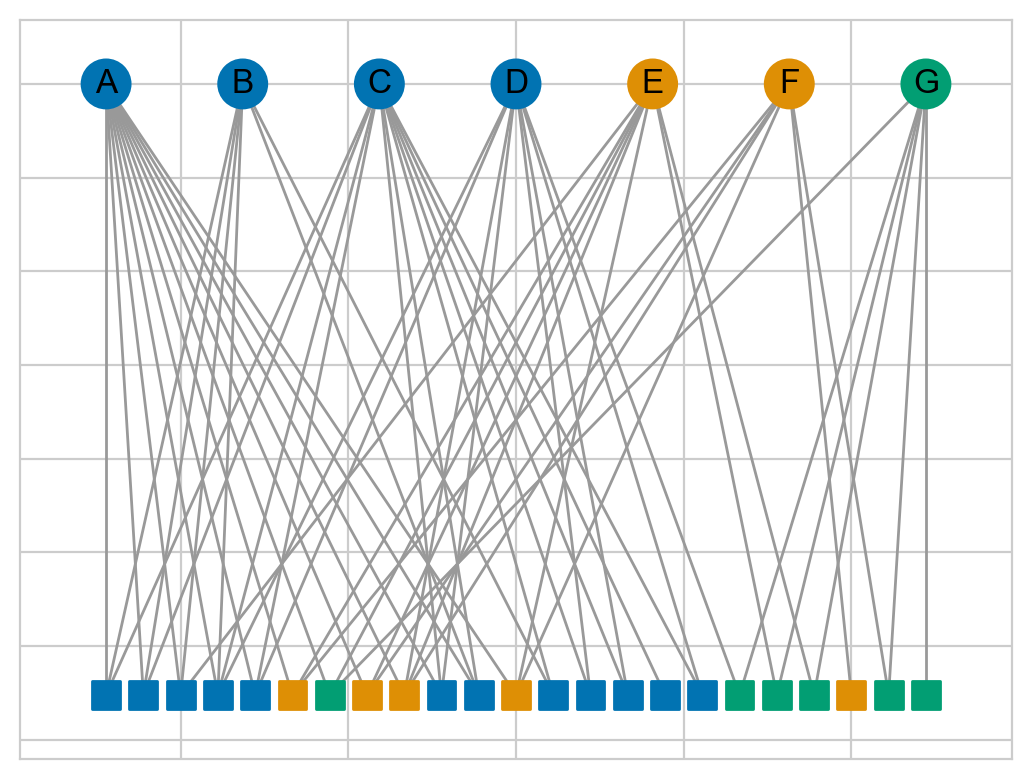

In [10]:
def draw_bipartite_network(G, df_nodes):
    n_modules = df_nodes["module"].nunique()
    palette = sns.color_palette(n_colors=n_modules)
    df_nodes["color"] = df_nodes.apply(lambda row: palette[row["module"]-1], axis=1)

    df_nodes_cells = df_nodes[df_nodes["type"] == "cell"]
    df_nodes_species = df_nodes[df_nodes["type"] == "species"]

    pos = nx.bipartite_layout(G, nodes=df_nodes_cells.index, align="horizontal")

    # Draw species
    nx.draw_networkx_nodes(G, pos, df_nodes_species.index, node_color=df_nodes_species["color"])
    # Draw species labels
    nx.draw_networkx_labels(G, pos, labels=df_nodes_species["name"].to_dict())
    # Draw cells
    nx.draw_networkx_nodes(G, pos, df_nodes_cells.index, node_size=100, node_shape='s', node_color=df_nodes_cells["color"])
    # Draw edges
    nx.draw_networkx_edges(G, pos, edge_color="#999999")

draw_bipartite_network(G, df_nodes)


The nodes are colored by the module, and each module contains both species and grid cells.

## Step 3 - Explore bioregions

<img src="https://www.mapequation.org/assets/img/bioregions/schematics-bioregions.svg" alt="step-3" height=200 style="background-color: white; padding: 10px">

Bioregions are defined by grid cells belonging to the same module, i.e. grid cells that are indirectly more tightly connected through shared species.

In [11]:
sp_name_to_module = df_nodes[df_nodes["type"] == "species"][["name", "module", "color"]].set_index("name")
df_records[["bioregion", "color"]] = df_records.apply(lambda row: sp_name_to_module.loc[row["species"]], axis=1, result_type="expand")
df_records

,long,lat,species,ilat,ilong,ilat_ilong,cell_id,species_id,bioregion,color
0,-28.625394,13.522421,A,0.0,-2.0,0.0_-2.0,0,23,1,"(0.00392156862745098, 0.45098039215686275, 0.6..."
1,-9.088009,29.941740,A,1.0,-1.0,1.0_-1.0,1,23,1,"(0.00392156862745098, 0.45098039215686275, 0.6..."
2,-35.019423,-1.254875,A,-1.0,-2.0,-1.0_-2.0,2,23,1,"(0.00392156862745098, 0.45098039215686275, 0.6..."
3,-16.651776,3.205244,A,0.0,-1.0,0.0_-1.0,3,23,1,"(0.00392156862745098, 0.45098039215686275, 0.6..."
4,3.135503,4.032686,A,0.0,0.0,0.0_0.0,4,23,1,"(0.00392156862745098, 0.45098039215686275, 0.6..."
...,...,...,...,...,...,...,...,...,...,...
1045,31.001705,-46.317136,G,-2.0,1.0,-2.0_1.0,18,29,3,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1046,40.511861,-30.114530,G,-2.0,1.0,-2.0_1.0,18,29,3,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1047,39.477023,-44.210069,G,-2.0,1.0,-2.0_1.0,18,29,3,"(0.00784313725490196, 0.6196078431372549, 0.45..."
1048,40.768708,-36.610475,G,-2.0,1.0,-2.0_1.0,18,29,3,"(0.00784313725490196, 0.6196078431372549, 0.45..."


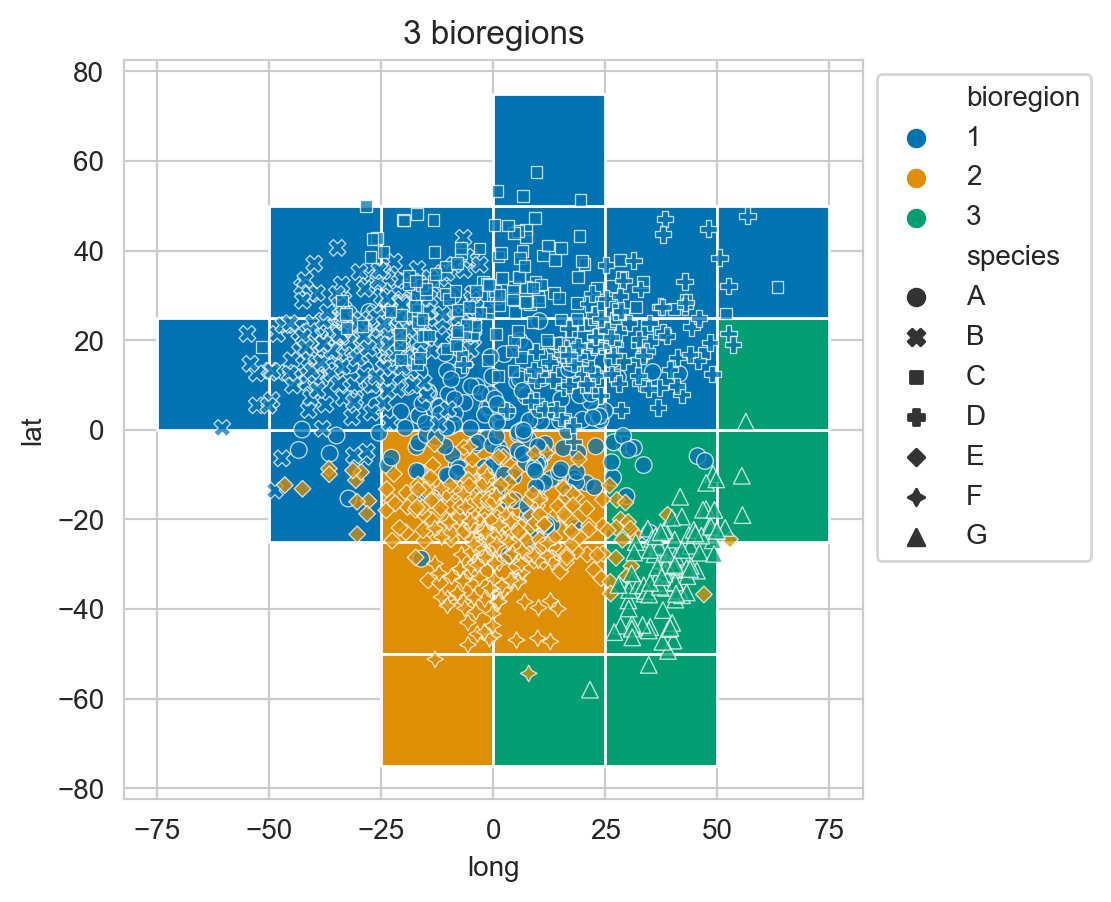

In [12]:
df_cells[["bioregion", "color"]] = df_nodes.loc[df_cells.index][["module", "color"]]
ax = df_cells.plot(color=df_cells["color"])
sns.scatterplot(df_records, x="long", y="lat", hue="bioregion", palette=sns.color_palette(n_colors=df_cells["bioregion"].max()), style="species", alpha=0.75, ax=ax)
ax.set(title=f"{df_cells['bioregion'].nunique()} bioregions")
ax.legend(bbox_to_anchor=(1, 1));

23 cells generated!
Created bipartite network with 30 nodes (23 cells and 7 species) and 57 edges.


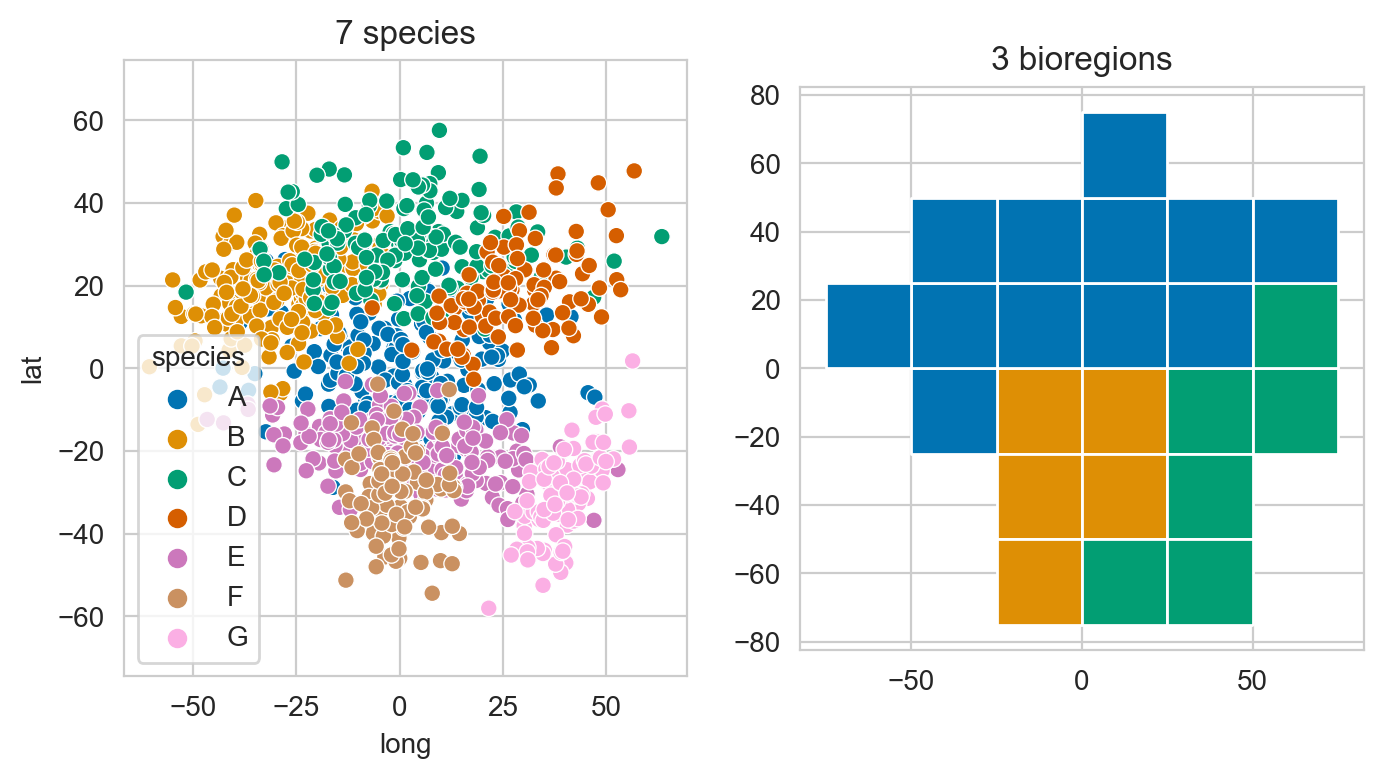

In [13]:
def run_all(species_params, resolution=20, seed=0):
    df_records = generate_species_distributions(species_params, seed=seed)
    df_cells = bin_species(df_records, resolution=resolution)
    df_nodes = generate_nodes(df_records, df_cells)
    G = generate_network(df_nodes, df_records)

    modules = util.partition(G, num_trials=10)
    df_nodes["module"] = modules
    n_modules = df_nodes["module"].nunique()
    palette = sns.color_palette(n_colors=n_modules)
    df_nodes["color"] = df_nodes.apply(lambda row: palette[row["module"]-1], axis=1)
    df_cells[["bioregion", "color"]] = df_nodes.loc[df_cells.index][["module", "color"]]

    _, axes = plt.subplots(ncols=2, figsize=(8,4))

    ax = axes[0]
    sns.scatterplot(df_records, x="long", y="lat", hue="species", ax=ax)
    ax.axis('equal')
    n_species = len(species_params)
    ax.set(title=f"{n_species} species")
    # ax.legend(loc="upper center", ncols=n_species // 2 + 1)
    
    ax = axes[1]
    df_cells.plot(color=df_cells["color"], ax=ax)
    ax.set(title=f"{df_cells['bioregion'].nunique()} bioregions")
    
    # axes[0].set(xlim=ax.get_xlim(), ylim=ax.get_ylim())
    axes[0].set(ylim=ax.get_ylim())
    # axes[0].set(xlim=ax.get_xlim())
    # axes[0].set(xlim=(-90, 90), ylim=(-90, 90))

run_all(species_params, resolution=25)

### Adapt the resolution to the data
Infomap Bioregions support adaptive resolution, where grid cells can be subdivided recursively to finer resolution where there are enough records.

Here we use a uniform resolution.

108 cells generated!
Created bipartite network with 115 nodes (108 cells and 7 species) and 195 edges.


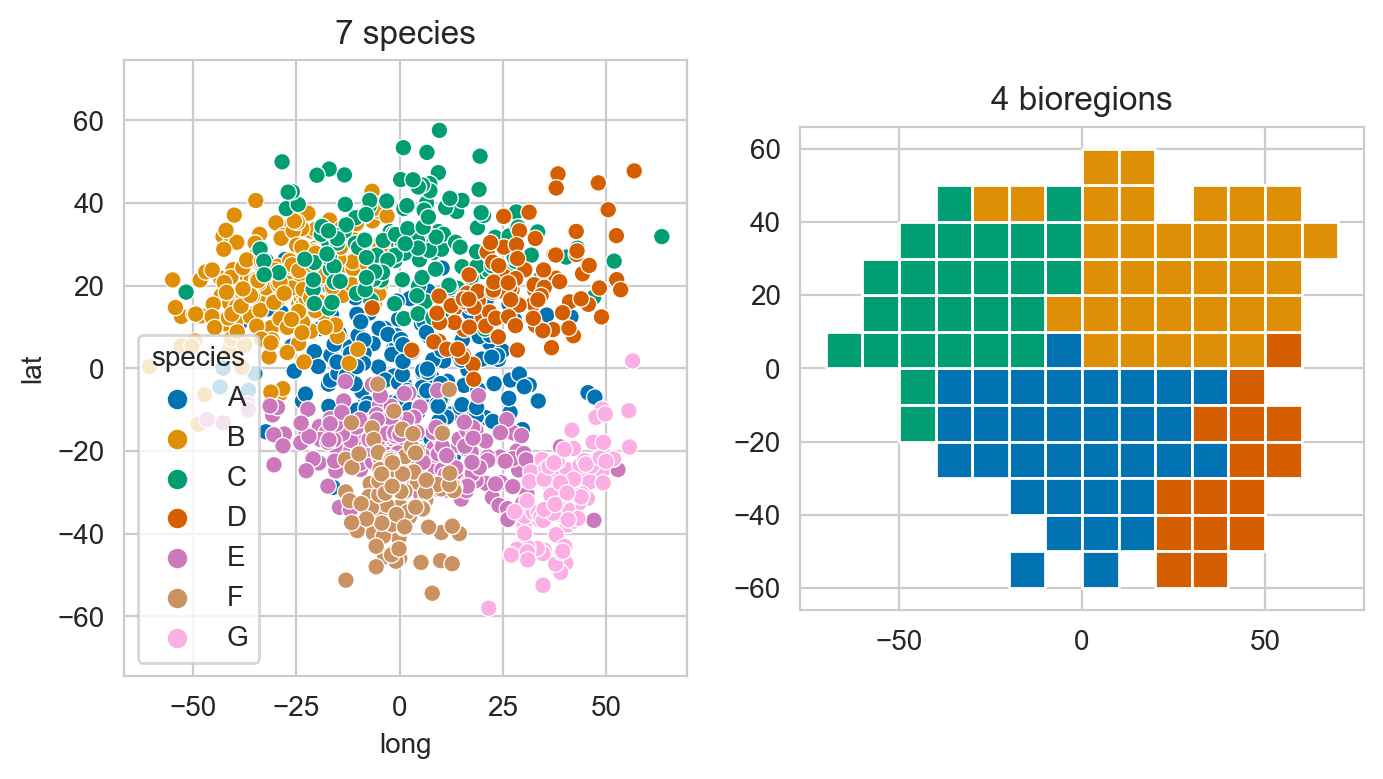

In [20]:
run_all(species_params, resolution=10)